In [213]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from geopy.distance import vincenty
import patsy
import statsmodels.api as sm

In [2]:
#extracts lat/long from Location 1 column
def findCoords(s):
    if s.find("(") == -1:
        print('help')
        return s
    return s[s.find("(")+1:s.find(")")]

#convert string in Location 1 column into x,y array
#if we wanna use tuple we can do that too
def strToCoord(s):
    coords = list(map(float,s.split(',')))
    #coords = tuple(map(float,test.split(',')))
    return coords

In [3]:
df = pd.read_csv('Parks.csv')

df = df.drop(df.columns[[3,4,5,11]], axis=1)
df = df[1:]
df = df[pd.notnull(df['Location 1'])]
df['Location 1'][78] = df['Location 1'][78][13:]
df['Location 1'] = df['Location 1'].apply(findCoords)

In [4]:
#make coordinates for plotting!!!
coords = []
for row in df.itertuples():
    coords.append(strToCoord(row._8))
coords = np.asarray(coords)

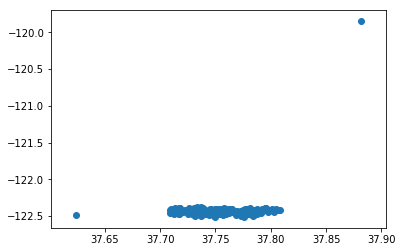

In [5]:
#scatter matrix
plt.scatter(coords.T[0],coords.T[1])
plt.show()

In [6]:
#Take out outliers
idx = 0
new_coords = []
for i,j in coords:
    if i < 37.65 or j > -120:
        print(idx,i,j)
    else:
        new_coords.append([i,j])
    idx += 1
new_coords = np.asarray(new_coords)
print(len(new_coords))

30 37.88160218 -119.85076005
170 37.62439438 -122.48189132
200


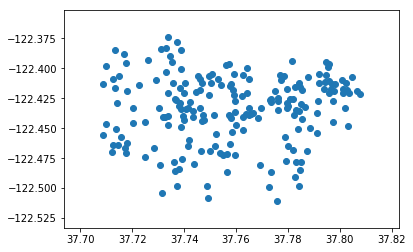

In [7]:
plt.scatter(new_coords.T[0],new_coords.T[1])
plt.show()

In [8]:
def getYear(s):
    if s.find("Y") == -1 or s.find("Q") == -1:
        print('help')
        return s
    return s[s.find("Y")+1:s.find("Q")]

In [9]:
df2 = pd.read_csv('Scores.csv')
df2 = df2.dropna()
df_all = pd.read_csv('Scores.csv')
df2['FQ'] = df2['FQ'].apply(getYear)
#take years 2012-2014
df2 = df2[(df2['FQ'] == '12') | (df2['FQ'] == '13') | (df2['FQ'] == '14')]

In [10]:
df12 = df2[df2['FQ'] == '12']
df13 = df2[df2['FQ'] == '13']
df14 = df2[df2['FQ'] == '14']

In [11]:
means_12 = dict()
for key in np.unique(np.array(df12['ParkID'])):
    means_12[key] = np.mean(np.array(df12[df12['ParkID'] == key]['Score']))
means_13 = dict()
for key in np.unique(np.array(df13['ParkID'])):
    means_13[key] = np.mean(np.array(df13[df13['ParkID'] == key]['Score']))
means_14 = dict()
for key in np.unique(np.array(df14['ParkID'])):
    means_14[key] = np.mean(np.array(df14[df14['ParkID'] == key]['Score']))

In [12]:
rows_list = []
for row in np.unique(df2['ParkID']):
    #print(row in df2['ParkID'], row in df['ParkID'])
    if row in list(df['ParkID']):
        dict1 = {}
        dict1['Park'] = list(df2[df2['ParkID'] == row]['Park'])[0]
        dict1['ParkID'] = row
        #print(row)
        dict1['Location'] = list(df[df['ParkID'] == int(row)]['Location 1'])[0]
        if row in means_12:
            dict1['mean_score_12'] = means_12[row]
        if row in means_13:
            dict1['mean_score_13'] = means_13[row]
        if row in means_14:
            dict1['mean_score_14'] = means_14[row]
        rows_list.append(dict1)
df_parks = pd.DataFrame(rows_list)

In [13]:
#df_parks[pd.isnull(df_test['mean_score_14'])]
#df_parks

In [162]:
np.save('Neighborhoods',np.array(nbrhoods))

In [16]:
coords = []
for row in df_parks.itertuples():
    coords.append(strToCoord(row.Location))
coords = np.asarray(coords)
len(coords)

155

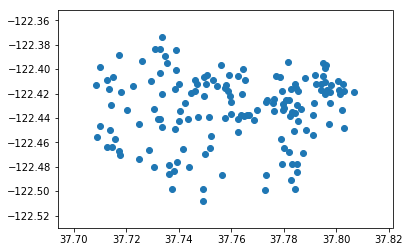

In [17]:
plt.scatter(coords.T[0],coords.T[1])
plt.show()

In [18]:
print(len(coords))

155


In [19]:
#CRIME DATA

In [20]:
def getCYear(s):
    year = s[8:10]
    #print(year)
    return year

In [21]:
####READING INTO CRIME DATA
crime_df = pd.read_csv('Police_Department_Incidents.csv')
crime_df = crime_df.dropna()
#print(list(crime_df.columns.values))
crime_df = crime_df.drop(['IncidntNum', 'Descript','DayOfWeek','Time','Resolution','Address','PdId'], axis=1)
#print(list(crime_df.columns.values))
crime_df["Date"] = crime_df["Date"].apply(getCYear)
crime_df['Location'] = crime_df['Location'].apply(lambda s:s[1:len(s)-1])
crime_df = crime_df[(crime_df['Date']=="12") | (crime_df['Date']=="13") | (crime_df['Date']=="14")]
#print(crime_df)

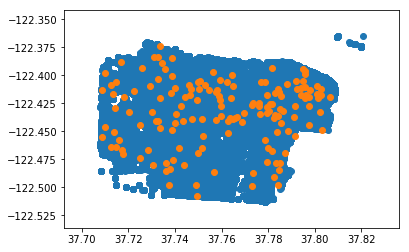

In [22]:
#scatter matrix
###What is our x and what is our y?????
plt.scatter(crime_df['Y'],crime_df['X'])
plt.scatter(coords.T[0],coords.T[1])
plt.show()

In [23]:
#cluster crime activity?

In [24]:
crime_locations = []
for i in crime_df['Location']:
    crime_locations.append(strToCoord(i))

In [25]:
def nearest(point,data):
    min_dist = 999999
    for val in data:
        temp = vincenty(point,val).feet
        if temp < min_dist:
            min_dist = temp
    return min_dist

def kNearestNeighbor(point, data, k=1):
    dist_array = []
    for val in data:
        dist_array.append(np.linalg.norm(point-val))
    enum_array = sorted(enumerate(dist_array),key=lambda i:i[1])
    indices = []
    for i in range(k):
        indices.append(enum_array[i][0])
    return indices

#units in feet
def numCrimesInRadius(point,data,rad=50):
    count = 0
    for val in data:
        if vincenty(point,val).feet <= 50:
            count += 1
    return count

In [26]:
#takes long time to run, just use:
nbrhoods = np.load('Neighborhoods.npy')


# nbrhoods = []
# for row in df_parks.itertuples():
#     coord = strToCoord(row.Location)
#     idx = kNearestNeighbor(np.array(coord),np.array(crime_locations))[0]
#     temp = str(crime_locations[idx])
#     temp = temp[1:len(temp)-1]
#     nbrhd = crime_df[crime_df['Location'] == temp]['PdDistrict'].value_counts().index[0]
#     nbrhoods.append(nbrhd)


In [178]:
# crimes_in_50_radius = []
# for row in df_parks.itertuples():
#     coord = strToCoord(row.Location)
#     count = numCrimesInRadius(np.array(coord),np.array(crime_locations))
#     crimes_in_50_radius.append(count)
    

In [27]:
df_parks['Neighborhood'] = pd.Series(np.array(nbrhoods), index=df_parks.index)

In [70]:
loc_dict = dict()
for idx,val in enumerate(nearests):
    loc_dict[crime_locs[idx]] = val

In [79]:
near_col = []
for cord in list(crime_df['Location']):
    near_col.append(loc_dict[cord])
crime_df['Dist_Nearest_Park'] = pd.Series(np.array(near_col),index=crime_df.index)

In [179]:
nearest([37.7774140531864, -122.480172525388],coords)

1020.6444403287782

In [181]:
for key in loc_dict:
    if loc_dict[key] != nearest(strToCoord(key),coords):
        print('help')

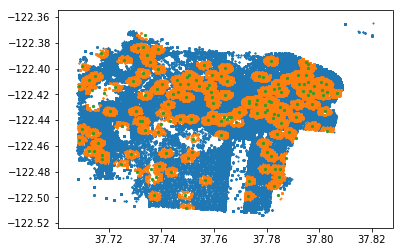

219322 within 1000 feet
224461 not within


In [209]:
test_dist = 1000
near_park = []
not_near = []
for idx,val in enumerate(crime_locations):
    if near_col[idx] < test_dist:
        near_park.append(val)
    else:
        not_near.append(val)
near_park = np.array(near_park)
not_near = np.array(not_near)      

plt.scatter(not_near.T[0],not_near.T[1],s=1)
plt.scatter(near_park.T[0],near_park.T[1],s=1)
plt.scatter(coords.T[0],coords.T[1],s=5)

plt.show()

print(len(near_park), "within", test_dist, "feet")
print(len(not_near), "not within")

In [206]:
# df_loc = pd.DataFrame(crime_locs)
# df_loc['dist_to_nearest_park'] = pd.Series(nearests,index=df_loc.index)
# df_loc

In [45]:
# nearests = []
# for idx,coord in enumerate(crime_locs):
#     nearests.append(nearest(strToCoord(crime_df['Location'].value_counts().index[idx]),coords))
nearests = np.load('nearests.npy')
#np.save('nearests',np.array(nearests))

In [167]:
list(crime_df['Location'].value_counts().index)

['37.775420706711, -122.403404791479',
 '37.7650501214668, -122.419671780296',
 '37.7564864109309, -122.406539115148',
 '37.7841893501425, -122.407633520742',
 '37.7642205603745, -122.41965834371',
 '37.7850629421661, -122.406520987144',
 '37.7833862379382, -122.409853729941',
 '37.769247063207, -122.426955631709',
 '37.7285280627465, -122.475647460786',
 '37.7865647607685, -122.407244087032',
 '37.7571580431915, -122.406604919508',
 '37.7850943210103, -122.407845374111',
 '37.7725405391593, -122.466204667893',
 '37.7804777480508, -122.412515341356',
 '37.7818621883021, -122.413869632554',
 '37.7839916768161, -122.408068345148',
 '37.7800332991006, -122.464279879446',
 '37.7827931071006, -122.414056291891',
 '37.7822305870036, -122.41029351969',
 '37.7817511307229, -122.411071423064',
 '37.7832145190013, -122.410768766343',
 '37.8096707013239, -122.365565425353',
 '37.7627436601147, -122.421747650463',
 '37.7852686309087, -122.403070000847',
 '37.779514030063, -122.413564091744',
 '37.

In [34]:
nearest(strToCoord(crime_df['Location'].value_counts().index[0]),coords)

937.110532567608

In [40]:
crime_locs = list(crime_df['Location'].value_counts().index)

In [150]:
cord = 162615
temp=str(crime_locations[cord])
temp=temp[1:len(temp)-1]
crime_df[crime_df['Location'] == temp]['PdDistrict'].value_counts().index[0]

'INGLESIDE'

In [109]:
# _sum = 0
# counter = 0
# for crime in crime_locations:
#     if counter%1000 == 0:
#         print(counter)
#     _sum += nearest(crime,coords)
#     counter += 1
# _sum/len(crime_locations)

In [119]:
crime_df['PdDistrict'].value_counts()

SOUTHERN      83993
MISSION       59380
NORTHERN      52864
CENTRAL       46157
BAYVIEW       43170
INGLESIDE     38548
TENDERLOIN    36164
TARAVAL       31751
PARK          27557
RICHMOND      24199
Name: PdDistrict, dtype: int64

In [121]:
df_parks['Neighborhood'].value_counts()

INGLESIDE     27
TARAVAL       20
NORTHERN      19
CENTRAL       18
MISSION       18
RICHMOND      17
BAYVIEW       16
PARK          12
TENDERLOIN     4
SOUTHERN       4
Name: Neighborhood, dtype: int64

In [125]:
df_parks = df_parks.fillna(-1)
means = []
for row in df_parks.itertuples():
    _mean = 0
    _tot = 0
    if row.mean_score_12 != -1:
        _mean += row.mean_score_12
        _tot += 1
    if row.mean_score_13 != -1:
        _mean += row.mean_score_13
        _tot += 1
    if row.mean_score_14 != -1:
        _mean += row.mean_score_14
        _tot += 1
    means.append(_mean/_tot)
    
means = np.array(means)
df_parks['score'] = pd.Series(means,index=df_parks.index)

In [141]:
nbrmeans = []
for n in df_nbr.index:
    nbrmeans.append(np.mean(np.array(df_parks[df_parks['Neighborhood'] == n]['score'])))
df_nbr['Avg_Score'] = pd.Series(nbrmeans,index=df_nbr.index)

In [154]:
numparks = []
for n in df_nbr.index:
    numparks.append(df_parks['Neighborhood'].value_counts()[n])
df_nbr['Num_Parks'] = pd.Series(numparks,index=df_nbr.index)

In [136]:
np.mean(np.array(df_parks[df_parks['Neighborhood'] == 'INGLESIDE']['score']))

0.92710592499064726

In [138]:
df_nbr = pd.DataFrame(crime_df['PdDistrict'].value_counts())
df_nbr

In [146]:
df_nbr = df_nbr.rename(index=str, columns={"Avg_Score": "Avg_Park_Score"})

In [147]:
df_nbr

,Num_Crimes,Avg_Park_Score
SOUTHERN,83993,0.922521
MISSION,59380,0.918019
NORTHERN,52864,0.927275
CENTRAL,46157,0.939610
BAYVIEW,43170,0.891632
INGLESIDE,38548,0.927106
TENDERLOIN,36164,0.923750
TARAVAL,31751,0.903539
PARK,27557,0.922279
RICHMOND,24199,0.930766


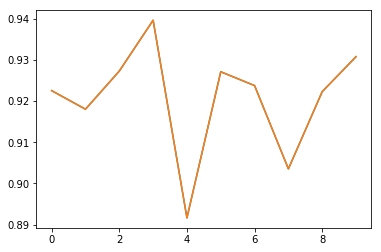

In [151]:
plt.plot(list(df_nbr['Avg_Park_Score']))
plt.show()

In [157]:
df_nbr.to_pickle('nbrhoods.pkl')

In [158]:
df_nbr

,Num_Crimes,Avg_Park_Score,Num_Parks
SOUTHERN,83993,0.922521,4
MISSION,59380,0.918019,18
NORTHERN,52864,0.927275,19
CENTRAL,46157,0.939610,18
BAYVIEW,43170,0.891632,16
INGLESIDE,38548,0.927106,27
TENDERLOIN,36164,0.923750,4
TARAVAL,31751,0.903539,20
PARK,27557,0.922279,12
RICHMOND,24199,0.930766,17


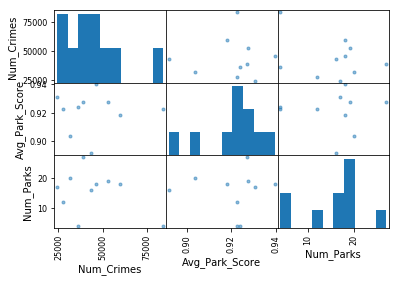

In [162]:
pd.scatter_matrix(df_nbr)
plt.show()

In [163]:
df_parks

,Location,Park,ParkID,Neighborhood,score
0,"37.7400257, -122.44273225",Glen Park,1,INGLESIDE,0.909750
1,"37.74058384, -122.43436978",Walter Haas Playground,4,INGLESIDE,0.914167
2,"37.74347014, -122.44055037",George Christopher Playground,7,INGLESIDE,0.945500
3,"37.74727823, -122.43893283",Douglass Playground,8,MISSION,0.879917
4,"37.73060291, -122.48041933",Rolph Nicol Playground,9,TARAVAL,0.906917
5,"37.72482337, -122.47385187",Junipero Serra Playground,13,TARAVAL,0.934278
6,"37.70860406, -122.4553029",Lessing-Sears Mini Park,14,INGLESIDE,0.850250
7,"37.71388814, -122.45029719",Cayuga Playground,15,INGLESIDE,0.981250
8,"37.71451213, -122.46369333",Randolph-Bright Mini Park,16,TARAVAL,0.885861
9,"37.71750931, -122.47028126",Merced Heights Playground,17,TARAVAL,0.912667


In [214]:
outcome, predictors = patsy.dmatrices('Num_Crimes ~ Num_Parks + Avg_Park_Score', df_nbr)
mod = sm.OLS(outcome, predictors)
res = mod.fit()

In [215]:
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:             Num_Crimes   R-squared:                       0.117
Model:                            OLS   Adj. R-squared:                 -0.136
Method:                 Least Squares   F-statistic:                    0.4619
Date:                Sun, 11 Jun 2017   Prob (F-statistic):              0.648
Time:                        23:15:08   Log-Likelihood:                -110.86
No. Observations:                  10   AIC:                             227.7
Df Residuals:                       7   BIC:                             228.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------
Intercept        1.41e+04   4.21e+05      0.

C:\Users\Reggie\Anaconda3\lib\site-packages\scipy\stats\stats.py:1327: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  "anyway, n=%i" % int(n))


In [216]:
crime_df

,Category,Date,PdDistrict,X,Y,Location,Dist_Nearest_Park
30,ARSON,14,NORTHERN,-122.420875,37.791494,"37.7914943051906, -122.420874632415",1359.059891
132,FRAUD,14,CENTRAL,-122.400749,37.791178,"37.7911776792224, -122.400748631911",1302.297966
280,VEHICLE THEFT,14,TARAVAL,-122.461139,37.709085,"37.7090849156407, -122.461139183524",1567.889369
305,ASSAULT,14,SOUTHERN,-122.403434,37.787643,"37.78764305018, -122.403434086745",1179.836537
324,ROBBERY,14,SOUTHERN,-122.417105,37.774324,"37.7743242867908, -122.417104895556",1883.040090
380,ASSAULT,14,BAYVIEW,-122.403595,37.727634,"37.7276340992506, -122.403595293514",1893.800571
515,ASSAULT,14,INGLESIDE,-122.421971,37.742375,"37.7423752245255, -122.421970919029",999.956016
533,NON-CRIMINAL,14,PARK,-122.446286,37.774871,"37.7748707258015, -122.446285631005",2699.186913
598,LARCENY/THEFT,14,NORTHERN,-122.432915,37.784353,"37.7843533426568, -122.432914603494",819.776893
599,NON-CRIMINAL,14,SOUTHERN,-122.394103,37.776383,"37.7763827130285, -122.394102624525",1892.894632
